### Modelling and Forecasting Brent Crude Oil with Auto Regressive Integrated Moving Average (ARIMA)


1. **Importing Libraries**: The first section of the code imports necessary libraries for data manipulation, visualization, and time series analysis.


In [1]:
#%%
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pmdarima as pm
from pmdarima import auto_arima
from pmdarima.arima import ndiffs, nsdiffs
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse
from math import sqrt
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")


2. **Loading Data**: The data is loaded from a pre processed CSV file into a pandas DataFrame. The index of the DataFrame is set to be the date.


In [2]:
#%%

# Load data from csv file
data = pd.read_csv('../data/Modified_Data.csv', index_col=[0], parse_dates=True)
data.head()

,Price
Date,
2002-01-01,19.96
2002-02-01,20.19
2002-03-01,24.03
2002-04-01,26.03
2002-05-01,25.69


The shape of the data shows the number of months and columns as (x,y)


In [3]:
data.shape

(252, 1)

3. **Plotting Data**: The data is plotted using `Plotly`, a Python graphing library. This provides a visual representation of the time series data.


In [4]:
#%%
# Plot data
fig = px.line(data, x=data.index, y='Price', title='Brent Crude Oil Prices')
fig.show()

**Checking Stationarity with Augmented Dickey-Fuller Test**: The Augmented Dickey-Fuller test is used to check if the time series is stationary. A stationary time series’ properties do not depend on the time at which the series is observed.


In [5]:
#%%

def adf_test(data):
    result = adfuller(data)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Number of lags used: %f' % result[2])
    if result[1] <= 0.05:
        print("Data is likely stationary.")
    else:
        print(f"Data may be non-stationary, consider differencing")

print("""Testing stationarity of data:""")
adf_test(data)

Testing stationarity of data:
ADF Statistic: -2.883602
p-value: 0.047288
Number of lags used: 1.000000
Data is likely stationary.


7. **Decomposing Time Series**: The time series is decomposed into trend, seasonal, and residual components.


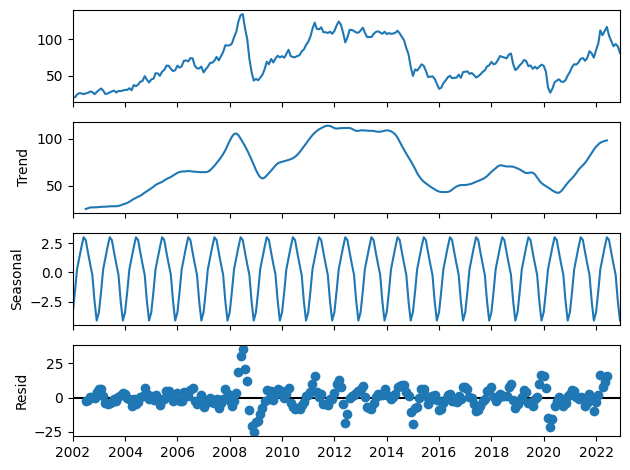

In [6]:
#%%

# Decompose time series into trend, seasonal, and residual components
result = seasonal_decompose(data, model='additive')
result.plot()
plt.show()

8. **Differencing to Make the Series Stationary**: If the series is not stationary, it is differenced. Differencing is the transformation of the series to make it stationary.


<Axes: title={'center': '2nd Differencing'}, xlabel='Date'>

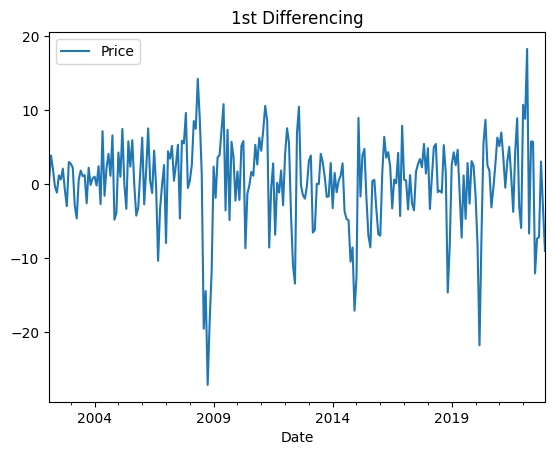

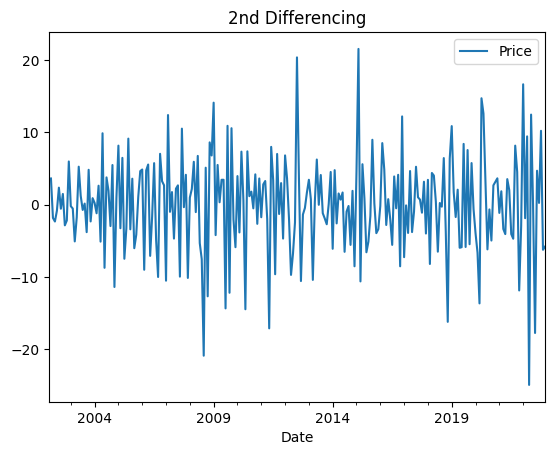

In [7]:
#%%

# Differencing to make the series stationary and plot the differenced series
diff = data.diff()[1:] # [1:] to remove NaN value
diff_2 = diff.diff()

# plot and add legend in top right corner with plotly subplots
diff.plot(title="1st Differencing")
diff_2.plot(title="2nd Differencing")


**Determining the Order of Differencing**: The ndiffs function is used to determine the minimum number of differencing needed to make the series stationary.


In [8]:
#%%

# number of  differencing for stationary series with ndiffs

# Adf Test
print('ADF:', ndiffs(data, test='adf'))
# KPSS test
print('KPSS:', ndiffs(data, test='kpss'))
# PP test:
print('PP:', ndiffs(data, test='pp'))

ADF: 1
KPSS: 1
PP: 1


**Determining the Order of the AR and MA terms**: The Partial Autocorrelation Function `PACF` and the Autocorrelation Function `ACF` are plotted to determine the order of the `AR` and `MA` terms.


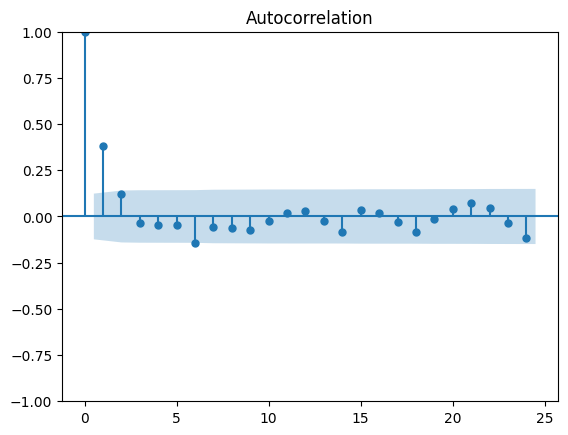

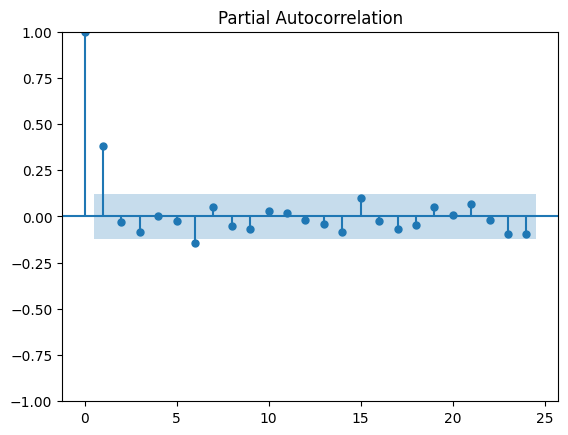

In [9]:
#%%
# Find order of MA term Q
plot_acf(diff).show()
# Order of auto regressive term P
plot_pacf(diff).show()

4. **Splitting Data into Train and Test Sets**:

- The data is split into training and testing sets based on a specified date.
- The training set is used to train the model, and
- The testing set is used to evaluate the model’s performance


In [10]:
#%%
# set the train and test data with start dates
train_start_date = '2002-01-01'
test_start_date = '2019-01-01'

# set the train and test data and print the dimensions of it
train = data.copy()[(data.index >= train_start_date) & (data.index < test_start_date)][['Price']]
test = data.copy()[data.index >= test_start_date][['Price']]

# train = data.iloc[:len(data)-24]
# test = data.iloc[len(data)-24:]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (204, 1)
Test data shape:  (48, 1)


5. **Plotting Train and Test Splits**: The training and testing data are plotted to visualize the split.


In [11]:
#%%

# Plot train and test splits
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train['Price'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=test.index, y=test['Price'], mode='lines', name='Test'))
fig.update_layout(title='Train and Test Split', xaxis_title='Date', yaxis_title='Price')
fig.show()

**Model Selection with Auto ARIMA**: The auto_arima function is used to automatically select the best `ARIMA` model based on the **Akaike Information Criterion** `AIC`.


In [12]:
#%%

# use auto_arima to find best parameters
model = pm.auto_arima(data, seasonal=True, stepwise=True, suppress_warnings=True, trace=True, error_action="ignore")
print(f"ARIMA Order: {model.order}")
print(f"Seasonal Order: {model.seasonal_order}")
print(f"AIC: {model.aic()}")
print(f"BIC: {model.bic()}")
print(f"HQIC: {model.hqic()}")


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1578.236, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1612.420, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1575.066, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1579.935, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1610.842, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1576.870, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1576.932, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1575.145, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1573.222, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1575.037, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1575.095, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1578.181, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1573.727, Time=0.16 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.101 seconds
ARIMA Order: (1, 1, 0)

**Model Diagnostics**: The residuals of the model are checked to ensure that the assumptions of the model are met.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -784.611
Date:                Sun, 07 Jul 2024   AIC                           1573.222
Time:                        13:34:11   BIC                           1580.273
Sample:                    01-01-2002   HQIC                          1576.060
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3831      0.043      8.923      0.000       0.299       0.467
sigma2        30.3674      2.072     14.656      0.000      26.306      34.429
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                47.35
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -0.71
Prob(H) (two-sided):                  0.62   Kurtosis:                         4.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

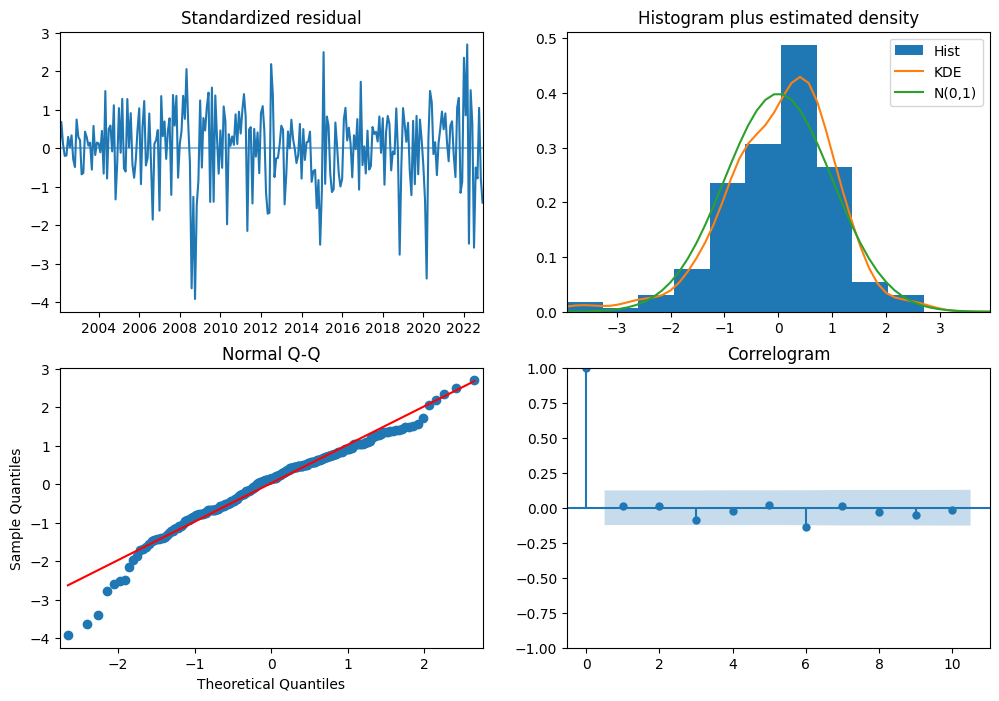

In [13]:
#%%
model.plot_diagnostics(figsize=(12, 8)).show()
model.summary()

**Model Fitting**: The model is fitted to the training data.


In [14]:
#%%
# Fit the model with the rraining set and best parameters found by auto_arima 
model = SARIMAX(train, order= model.order)
model_fit = model.fit()
# residuals = model_fit.resid

# Print the summary of the model
model_fit.summary(alpha=0.05)
model_fit.summary(alpha=0.10)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  204
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -624.444
Date:                Sun, 07 Jul 2024   AIC                           1252.888
Time:                        13:34:12   BIC                           1259.514
Sample:                    01-01-2002   HQIC                          1255.568
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|       [0.05       0.95]
------------------------------------------------------------------------------
ar.L1          0.4152      0.047      8.894      0.000       0.338       0.492
sigma2        27.4768      2.023     13.585      0.000      24.150      30.804
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                45.36
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                            -0.74
Prob(H) (two-sided):                  0.19   Kurtosis:                         4.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Model Prediction**: The model is used to make predictions on the test data.


In [15]:
test.head()

,Price
Date,
2019-01-01,60.23
2019-02-01,64.50
2019-03-01,67.05
2019-04-01,71.66
2019-05-01,70.30


In [16]:
# dynamic=False means that forecasts at each point are generated using the full history up to that point
predictions = model_fit.predict(start=test.index[0], end=test.index[-1], dynamic=False)
residuals = test['Price'] - predictions

In [17]:
predictions.tail()

2022-08-01    51.783188
2022-09-01    51.783188
2022-10-01    51.783188
2022-11-01    51.783188
2022-12-01    51.783188
Freq: MS, Name: predicted_mean, dtype: float64

Plots of the residuals of after fitting the model


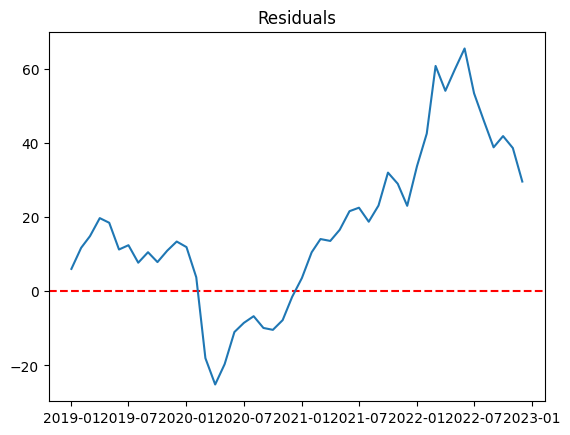

In [18]:
# Plot residuals
plt.axhline(y=0, color='red', linestyle='--')
plt.plot(residuals)
plt.title('Residuals')
plt.show()


15. **Model Evaluation**: The model’s performance is evaluated using the **Root Mean Squared Error** `RMSE`, **Mean Absolute Error** `MAE`, and **Mean Absolute Percentage Error** `MAPE`.


In [19]:
#%%

# Calculate evaluation metrics
print(""" Error Metrics """)

mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
mae = mean_absolute_error(test, predictions)
mape = mean_absolute_percentage_error(test, predictions)


print(f'Mean Squared Error: {mse:.3f}')
print(f'Mean Absolute Error: {mae:.3f}')
print(f'Root Mean Squared Error: {rmse:.3f}')
print(f'Mean Absolute Percentage Error: {mape*100:.3f}%')




 Error Metrics 
Mean Squared Error: 769.664
Mean Absolute Error: 22.322
Root Mean Squared Error: 27.743
Mean Absolute Percentage Error: 30.476%


16. **Plotting Actual vs Predicted Prices**: The actual and predicted prices are plotted.


In [20]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test.index, y=test['Price'], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=test.index, y=predictions, mode='lines', name='Predicted'))
fig.update_layout(title='Actual vs Predicted Prices', xaxis_title='Date', yaxis_title='Price')
fig.show()


17. **Forecasting Future Prices**: The model is used to forecast future prices.


In [21]:
# Forecasting with confidence intervals for the next 24 months

future_dates = pd.date_range(start='2023-01-01', periods=24, freq='M') 

# Forecast with 95% confidence interval
forecast_obj_95 = model_fit.get_prediction(start=future_dates[0], end=future_dates[-1])
forecast_95 = forecast_obj_95.predicted_mean
conf_int_95 = forecast_obj_95.conf_int(alpha=0.05)

# Forecast with 90% confidence interval
forecast_obj_90 = model_fit.get_prediction(start=future_dates[0], end=future_dates[-1])
conf_int_90 = forecast_obj_90.conf_int(alpha=0.10)

# Plot the forecast with confidence intervals
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Price'], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=future_dates, y=forecast_95, mode='lines', name='Forecast'))
fig.add_trace(go.Scatter(x=future_dates, y=conf_int_95.iloc[:, 0], mode='lines', name='Lower 95% CI', line=dict(color='rgba(255,0,0,0.5)')))
fig.add_trace(go.Scatter(x=future_dates, y=conf_int_95.iloc[:, 1], mode='lines', name='Upper 95% CI', line=dict(color='rgba(255,0,0,0.5)'), fill='tonexty'))
fig.add_trace(go.Scatter(x=future_dates, y=conf_int_90.iloc[:, 0], mode='lines', name='Lower 90% CI', line=dict(color='rgba(0,0,255,0.5)')))
fig.add_trace(go.Scatter(x=future_dates, y=conf_int_90.iloc[:, 1], mode='lines', name='Upper 90% CI', line=dict(color='rgba(0,0,255,0.5)'), fill='tonexty'))
fig.update_layout(title='Brent Crude Oil Price Forecast (with Confidence Intervals)', xaxis_title='Date', yaxis_title='Price')
fig.show()


Applying a rolling window forecast


In [22]:
# use rolling window to forecast the next 24 months
window_size = 24 # 24 months
forecast = [] # to store the forecasted values
for i in range(len(test)):
    train_window = train.append(test.iloc[:i]) # add the test data to the training data
    model = SARIMAX(train_window, order=model.order) # create the model
    model_fit = model.fit() # fit the model
    forecast.append(model_fit.forecast(steps=1)[0]) # forecast the next month

# Calculate evaluation metrics
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = sqrt(mse)
mape = mean_absolute_percentage_error(test, forecast)



AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
print(f'Mean Squared Error: {mse:.3f}')
print(f'Root Mean Squared Error: {rmse:.3f}')
print(f'Mean Absolute Error: {mae:.3f}')
print(f'Mean Absolute Percentage Error: {mape*100:.3f}%')

In [ ]:
# plot the actual and forecasted values
fig = go.Figure()
fig.add_trace(go.Scatter(x=test.index, y=test['Price'], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=test.index, y=forecast, mode='lines', name='Forecast'))
fig.update_layout(title='Actual vs Forecasted Prices', xaxis_title='Date', yaxis_title='Price')
fig.show()

In [ ]:
# plot the residuals
residuals = test['Price'] - forecast
plt.axhline(y=0, color='red', linestyle='--')
plt.plot(residuals)
plt.title('Residuals')
plt.show()

In [ ]:
# Forecast with confidence intervals for the next 24 months
future_dates = pd.date_range(start='2023-01-01', periods=24, freq='M')

# Forecast with 95% confidence interval
forecast_obj_95 = model_fit.get_prediction(start=future_dates[0], end=future_dates[-1])
forecast_95 = forecast_obj_95.predicted_mean
conf_int_95 = forecast_obj_95.conf_int(alpha=0.05)

# Forecast with 90% confidence interval
forecast_obj_90 = model_fit.get_prediction(start=future_dates[0], end=future_dates[-1])
forecast_90 = forecast_obj_90.predicted_mean
conf_int_90 = forecast_obj_90.conf_int(alpha=0.10)

# Plot the forecast with confidence intervals
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Price'], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=future_dates, y=forecast_95, mode='lines', name='Forecast'))
fig.add_trace(go.Scatter(x=future_dates, y=conf_int_95.iloc[:, 0], mode='lines', name='Lower 95% CI', line=dict(color='rgba(255,0,0,0.5)')))
fig.add_trace(go.Scatter(x=future_dates, y=conf_int_95.iloc[:, 1], mode='lines', name='Upper 95% CI', line=dict(color='rgba(255,0,0,0.5)'), fill='tonexty'))
fig.add_trace(go.Scatter(x=future_dates, y=conf_int_90.iloc[:, 0], mode='lines', name='Lower 90% CI', line=dict(color='rgba(0,0,255,0.5)')))
fig.add_trace(go.Scatter(x=future_dates, y=conf_int_90.iloc[:, 1], mode='lines', name='Upper 90% CI', line=dict(color='rgba(0,0,255,0.5)'), fill='tonexty'))
fig.update_layout(title='Brent Crude Oil Price Forecast (with Confidence Intervals)', xaxis_title='Date', yaxis_title='Price')
fig.show()
